# 08_2_DESIGN_TargetedLibrary

<a target="_blank" href="https://colab.research.google.com/github/hiyama341/ConStrain/blob/main/colab_notebooks/08_2_DESIGN_TargetedLibrary.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [44]:
%%capture
!pip install pydna
!pip install pandas
!pip install --upgrade xlrd
!pip install constrain

In [45]:
import IPython.core.display
import pathlib
import itertools
import numpy as np
import pandas as pd
import copy
import pydna
import pydna.editor
import pydna.primer
import pydna.dseqrecord
import pydna.amplify
import pydna.assembly
import pydna.gel
import pydna.ladders
from pydna.dseqrecord import Dseqrecord
import matplotlib.pyplot as plt
import numpy as np

In [46]:
!git clone https://github.com/hiyama341/ConStrain_on_google_colab.git

fatal: destination path 'ConStrain_on_google_colab' already exists and is not an empty directory.


# 1. Debottlenecking the strictosidine module

## Hypothesis
1. Specific combinations of CPR / G8H homologs and corresponding expression levels can remove the G8H bottleneck in the Strictosidine pathway

### Aim: To test the hypothesis through library design

Tasks
1. analyse seq data from first library construction
2. **2nd Library**
    - investigate parts already in the lab
    - create parts missing
    - pool together parts
    - transformation
4. Phenotyping
5. Data analysis

# 2. Intro

The purpose of this notebook is to create a smaller library based on a machine learning prediction of the highest producing combination of genes from combinations seen in the figure below. 

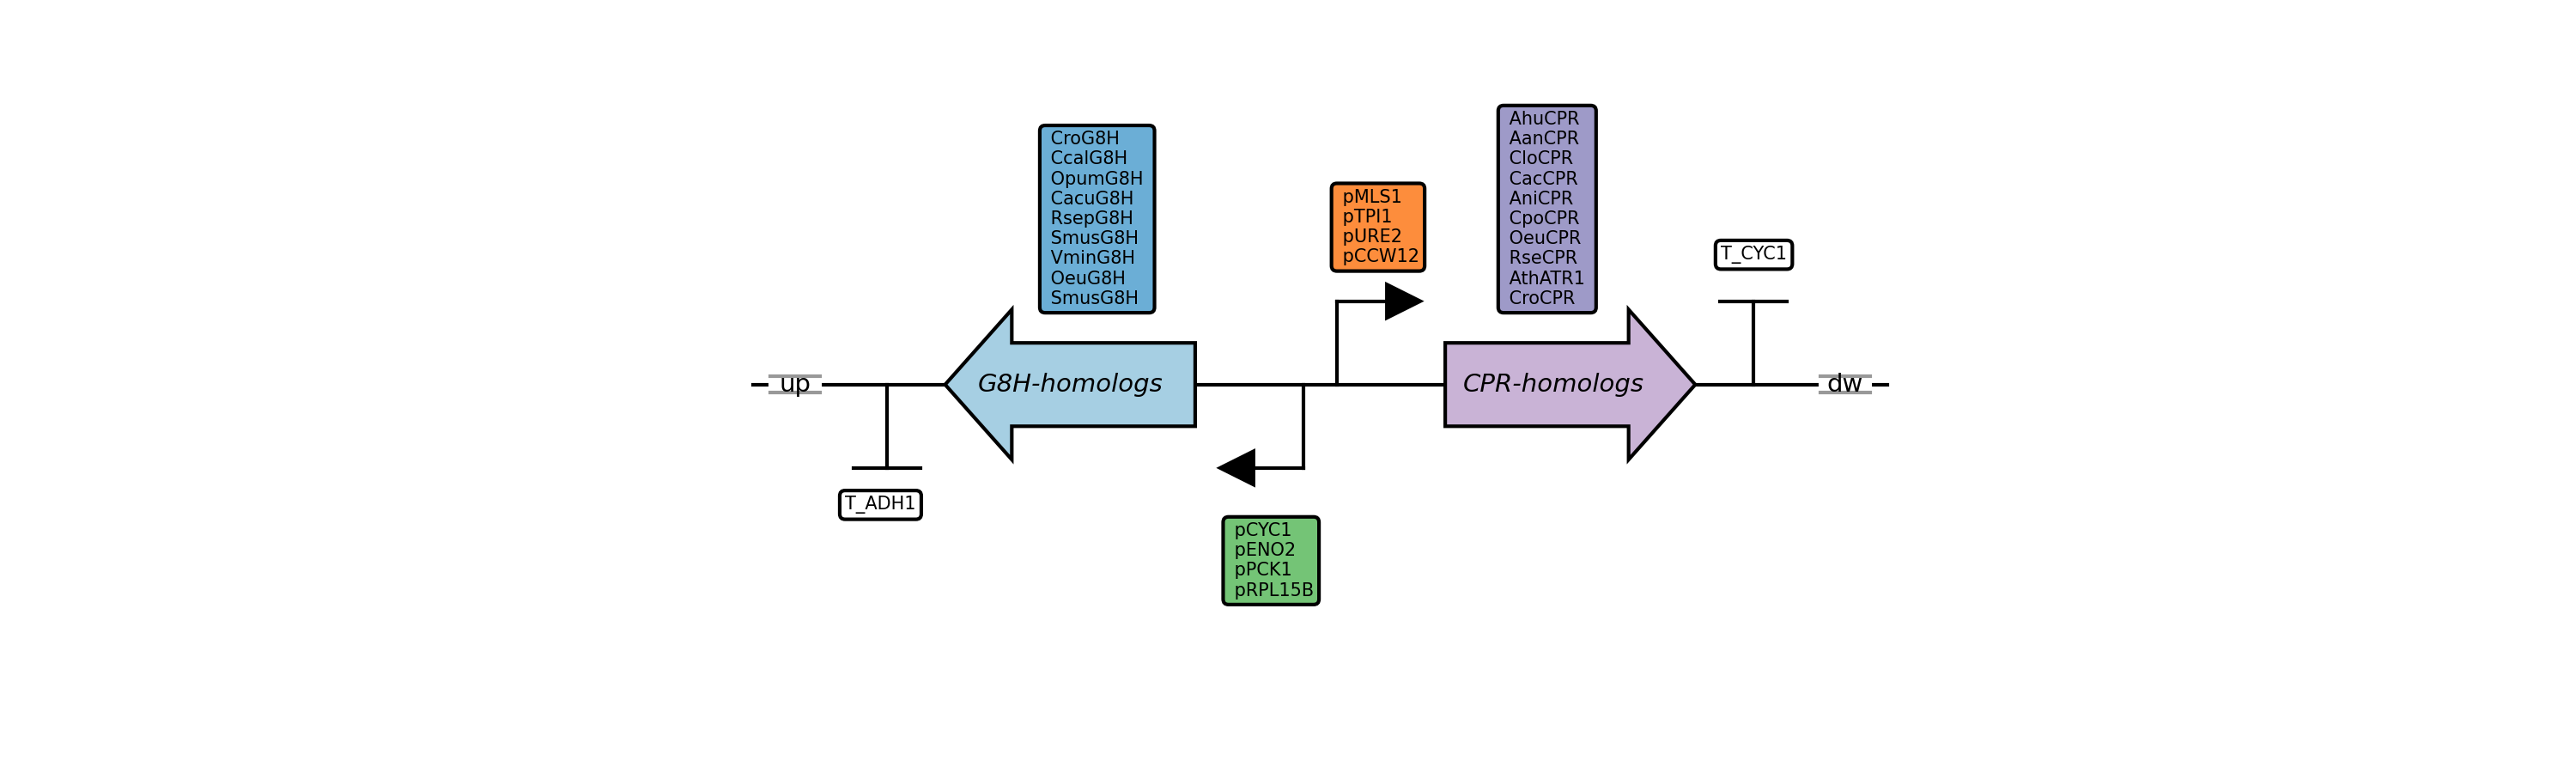

In [47]:
IPython.core.display.Image('ConStrain_on_google_colab/pictures/Genetic construct w dnaplotlib.png', width=2000)

The figure above illustrates the original library design.

Note on sequence homology: 
- As G8H and CPR parts have homology this library cannot be made in one-pot transformation. Instead it is made in 9*10 individual transformation to not add two G8H or CPR homologs in one transformation mixtures.

Machine learning pred:
- In the following, the machine learning outcome can be found. It was found that 140 strains (5*2*2*7)was suitable for the pupose.
- From the predictions, the following genes have been selected: 
    - Smus, Vmin, Cro, Rsep, Oeu
    - pCYC1, pENO2
    - Clo, Ara, Rse, Aan, Cro, Ani, Ahu
    - pTPI1, pCCW12

Experiment:
- To perform this experiment, a total of 35 (5*7) transformation should be performed 
- To perform this, each gene has several different overhangs and these are pooled together. All promoters are also pooled together. UP, DW and cTRP1 is pooled together. Then the correct mixes should be performed. 

The previous experiments were simulated in [05_1_BUILD_CombinatorialLibrary_AllStrains](05_1_BUILD_CombinatorialLibrary_AllStrains.ipynb), and the next step in the process was investigation of the machine learning outcome.

# 3. Machine Learning outcome
- 240 strains were sampled, and from these 149 strains were accepted.
- Many top produceres were nnot included, therefore the top 20 non sequenced producers were resequenced. See Second sequnecing (this is placed later to allow for simulation)


This resulted in:
- From 480 sequence reads, 399 were accepted
- 175 of the strains had accepted sequence data for G8H and CPR and strictodisine data 
- 9 doublicates -> 166 unique strains



## 3.1 Getting parts based on MAE

In [48]:
#Get prediction data
# first iteration with Christine
df = pd.read_csv('ConStrain_on_google_colab/Data/processed/ML_First_lib_predicted/Predicted_strict_named_CMP_MAE.csv')

# 1st analytics
df2 = pd.read_csv('ConStrain_on_google_colab/Data/Plots_for_publication/ML_DBTL1/predicted_unseen_comb_ML1_trained_on_1st_analytics".csv')


list_of_dfs = [df, df2]

In [49]:
df

,G8H,pG8H,pCPR,CPR,predict
0,Cro,ENO2,TPI1,Ara,154
1,Cro,ENO2,TPI1,Clo,152
2,Smus,ENO2,TPI1,Aan,129
3,Smus,ENO2,CCW12,Clo,125
4,Cro,ENO2,TPI1,Rse,123
...,...,...,...,...,...
1133,Cacu,ENO2,MLS1,Cro,-3
1134,Cacu,ENO2,MLS1,Clo,-4
1135,Cacu,ENO2,MLS1,Ahu,-4
1136,Cacu,ENO2,MLS1,Ani,-4


Parts distribution - bar chart

In [50]:


#Iterate through the list of predictions and save new encountered parts. Stop after 180 combiantions.
#Initialisation
parts_encounteres = {'G8H':[],'pG8H':[], 'pCPR': [], 'CPR': []}
sum_of_parts = 0
i = 0
g8h_count = 0
cpr_count = 0
pg8h_count = 0
pcpr_count = 0

#Loop through the predctions and save new parts. 
while sum_of_parts < 180:
    g8h = df.G8H[i]
    pg8h = df.pG8H[i]
    cpr = df.CPR[i]
    pcpr = df.pCPR[i]
    old_sum = copy.copy(sum_of_parts)
    if g8h not in parts_encounteres['G8H']:
        parts_encounteres['G8H'].append(g8h)
        g8h_count += 1
    if pg8h not in parts_encounteres['pG8H']:
        parts_encounteres['pG8H'].append(pg8h)
        pg8h_count += 1
    if cpr not in parts_encounteres['CPR']:
        parts_encounteres['CPR'].append(cpr)
        cpr_count += 1
    if pcpr not in parts_encounteres['pCPR']:
        parts_encounteres['pCPR'].append(pcpr)
        pcpr_count += 1
    sum_of_parts =  g8h_count*cpr_count*pg8h_count*pcpr_count
    if sum_of_parts > old_sum:
        print("Prediction", i+1)
        print('G8H: ',parts_encounteres['G8H'])
        print('pG8H:',parts_encounteres['pG8H'])
        print('pCPR:',parts_encounteres['pCPR'])
        print('CPR: ',parts_encounteres['CPR'])
        print("Number of combinations", sum_of_parts)
        print(g8h_count, pg8h_count, pcpr_count,cpr_count)
        print('\n')
    i += 1
                          


Prediction 1
G8H:  ['Cro']
pG8H: ['ENO2']
pCPR: ['TPI1']
CPR:  ['Ara']
Number of combinations 1
1 1 1 1


Prediction 2
G8H:  ['Cro']
pG8H: ['ENO2']
pCPR: ['TPI1']
CPR:  ['Ara', 'Clo']
Number of combinations 2
1 1 1 2


Prediction 3
G8H:  ['Cro', 'Smus']
pG8H: ['ENO2']
pCPR: ['TPI1']
CPR:  ['Ara', 'Clo', 'Aan']
Number of combinations 6
2 1 1 3


Prediction 4
G8H:  ['Cro', 'Smus']
pG8H: ['ENO2']
pCPR: ['TPI1', 'CCW12']
CPR:  ['Ara', 'Clo', 'Aan']
Number of combinations 12
2 1 2 3


Prediction 5
G8H:  ['Cro', 'Smus']
pG8H: ['ENO2']
pCPR: ['TPI1', 'CCW12']
CPR:  ['Ara', 'Clo', 'Aan', 'Rse']
Number of combinations 16
2 1 2 4


Prediction 6
G8H:  ['Cro', 'Smus', 'Rsep']
pG8H: ['ENO2']
pCPR: ['TPI1', 'CCW12']
CPR:  ['Ara', 'Clo', 'Aan', 'Rse']
Number of combinations 24
3 1 2 4


Prediction 7
G8H:  ['Cro', 'Smus', 'Rsep']
pG8H: ['ENO2']
pCPR: ['TPI1', 'CCW12']
CPR:  ['Ara', 'Clo', 'Aan', 'Rse', 'Cro']
Number of combinations 30
3 1 2 5


Prediction 21
G8H:  ['Cro', 'Smus', 'Rsep', 'Opum']
pG8H:

In [51]:
def parts_encountered(df): 
    #Iterate through the list of predictions and save new encountered parts. Stop after 180 combiantions.
    #Initialisation
    parts_encounteres = {'G8H':[],'pG8H':[], 'pCPR': [], 'CPR': [], 'Sum of parts':''}
    sum_of_parts = 0
    i = 0
    g8h_count = 0
    cpr_count = 0
    pg8h_count = 0
    pcpr_count = 0

    #Loop through the predctions and save new parts. 
    while sum_of_parts < 140:
        sum_of_parts =  g8h_count*cpr_count*pg8h_count*pcpr_count

        parts_encounteres['Sum of parts'] = str(sum_of_parts)
        g8h = df.G8H[i]
        pg8h = df.pG8H[i]
        cpr = df.CPR[i]
        pcpr = df.pCPR[i]
        old_sum = copy.copy(sum_of_parts)
        if g8h not in parts_encounteres['G8H']:
            parts_encounteres['G8H'].append(g8h)
            g8h_count += 1
        if pg8h not in parts_encounteres['pG8H']:
            parts_encounteres['pG8H'].append(pg8h)
            pg8h_count += 1
        if cpr not in parts_encounteres['CPR']:
            parts_encounteres['CPR'].append(cpr)
            cpr_count += 1
        if pcpr not in parts_encounteres['pCPR']:
            parts_encounteres['pCPR'].append(pcpr)
            pcpr_count += 1
        
        #sum_of_parts =  g8h_count*cpr_count*pg8h_count*pcpr_count
        i += 1

    
    return parts_encounteres

In [52]:
def parts_encountered(df): 
    #Iterate through the list of predictions and save new encountered parts. Stop after 180 combiantions.
    #Initialisation
    parts_encounteres = {'G8H':[],'pG8H':[], 'pCPR': [], 'CPR': [], 'Sum of parts':''}
    sum_of_parts = 0
    i = 0
    g8h_count = 0
    cpr_count = 0
    pg8h_count = 0
    pcpr_count = 0

    #Loop through the predctions and save new parts. 
    while sum_of_parts < 140:
        sum_of_parts =  g8h_count*cpr_count*pg8h_count*pcpr_count

        parts_encounteres['Sum of parts'] = str(sum_of_parts)
        g8h = df.G8H[i]
        pg8h = df.pG8H[i]
        cpr = df.CPR[i]
        pcpr = df.pCPR[i]
        old_sum = copy.copy(sum_of_parts)
        if g8h not in parts_encounteres['G8H']:
            parts_encounteres['G8H'].append(g8h)
            g8h_count += 1
        if pg8h not in parts_encounteres['pG8H']:
            parts_encounteres['pG8H'].append(pg8h)
            pg8h_count += 1
        if cpr not in parts_encounteres['CPR']:
            parts_encounteres['CPR'].append(cpr)
            cpr_count += 1
        if pcpr not in parts_encounteres['pCPR']:
            parts_encounteres['pCPR'].append(pcpr)
            pcpr_count += 1
        
        #sum_of_parts =  g8h_count*cpr_count*pg8h_count*pcpr_count
        i += 1

    
    return parts_encounteres

In [53]:
parts = parts_encountered(df)
parts

{'G8H': ['Cro', 'Smus', 'Rsep', 'Opum', 'Vmin'],
 'pG8H': ['ENO2', 'CYC1'],
 'pCPR': ['TPI1', 'CCW12'],
 'CPR': ['Ara', 'Clo', 'Aan', 'Rse', 'Cro', 'Cac', 'Oeu'],
 'Sum of parts': '140'}

In [54]:
for k,v in parts.items(): 
    parts[k] = set(parts[k])
    
for k,v in parts.items(): 
    parts[k] = set(parts[k])
#parts['G8H'] = set(parts['G8H'])
parts

{'G8H': {'Cro', 'Opum', 'Rsep', 'Smus', 'Vmin'},
 'pG8H': {'CYC1', 'ENO2'},
 'pCPR': {'CCW12', 'TPI1'},
 'CPR': {'Aan', 'Ara', 'Cac', 'Clo', 'Cro', 'Oeu', 'Rse'},
 'Sum of parts': {'0', '1', '4'}}

In [55]:
list_of_analysis = ['1st_ana_CH', '1st_ana', '2nd_ana', 'merged', 'merged_ranked']

In [56]:
for i in range(len(list_of_dfs)): 
    parts = parts_encountered(list_of_dfs[i])
    print('\n')
    print(f"{i} : {list_of_analysis[i]}")
    for k,v in parts.items(): 
        print(k,v)



0 : 1st_ana_CH
G8H ['Cro', 'Smus', 'Rsep', 'Opum', 'Vmin']
pG8H ['ENO2', 'CYC1']
pCPR ['TPI1', 'CCW12']
CPR ['Ara', 'Clo', 'Aan', 'Rse', 'Cro', 'Cac', 'Oeu']
Sum of parts 140


1 : 1st_ana
G8H ['Smus', 'Rsep', 'Oeu', 'Cro']
pG8H ['ENO2', 'CYC1']
pCPR ['TPI1', 'CCW12', 'URE2']
CPR ['Rse', 'Ara', 'Aan', 'Cac', 'Cro', 'Oeu', 'Clo']
Sum of parts 168


In [57]:
parts_1st_ml = parts_encountered(df)
parts_2nd_ml = parts_encountered(df2)


# we are changing the names and adding them to a list
## Ml1
list_of_parts_1st_ml_G8H = []
list_of_parts_1st_ml_pG8H = []
list_of_parts_1st_ml_pCPR = []
list_of_parts_1st_ml_CPR = []

# Ml2
list_of_parts_2nd_ml_G8H = []
list_of_parts_2nd_ml_pG8H = []
list_of_parts_2nd_ml_pCPR = []
list_of_parts_2nd_ml_CPR = []

list_of_parts_2st_ml = []

# 1st ml
for k, v in parts_1st_ml.items():
    if k == 'G8H':
        for value in v:
            value = value+'G8H'
            list_of_parts_1st_ml_G8H.append(value)
    if k == 'CPR':
        for value in v:
            value = value+'CPR'
            list_of_parts_1st_ml_CPR.append(value)        
    if k == 'pG8H':
        for value in v:
            value = value
            list_of_parts_1st_ml_CPR.append(value)         
    if k == 'pCPR':
        for value in v:
            value = value
            list_of_parts_1st_ml_pCPR.append(value)
            
#2nd ml
for k, v in parts_2nd_ml.items():
    if k == 'G8H':
        for value in v:
            value = value+'G8H'
            list_of_parts_2nd_ml_G8H.append(value)
    if k == 'CPR':
        for value in v:
            value = value+'CPR'
            list_of_parts_2nd_ml_CPR.append(value)       
    if k == 'pG8H':
        for value in v:
            value = value
            list_of_parts_2nd_ml_pG8H.append(value)      
    if k == 'pCPR':
        for value in v:
            value = value
            list_of_parts_2nd_ml_pCPR.append(value)


## Venn diagram

In [58]:
%%capture
!pip install venn

In [59]:
import matplotlib
matplotlib.use('Agg')

import venn

In [63]:
parts_1st_ml = parts_encountered(df)
parts_2nd_ml = parts_encountered(df2)

for k,v in parts_1st_ml.items(): 
    parts_1st_ml[k] = set(parts_1st_ml[k])
    
for k,v in parts_2nd_ml.items(): 
    parts_2nd_ml[k] = set(parts_2nd_ml[k])
parts_2nd_ml

{'G8H': {'Cro', 'Oeu', 'Rsep', 'Smus'},
 'pG8H': {'CYC1', 'ENO2'},
 'pCPR': {'CCW12', 'TPI1', 'URE2'},
 'CPR': {'Aan', 'Ara', 'Cac', 'Clo', 'Cro', 'Oeu', 'Rse'},
 'Sum of parts': {'1', '6', '8'}}

In [64]:
parts_1st_ml.pop('Sum of parts', None)
parts_2nd_ml.pop('Sum of parts', None)

{'1', '6', '8'}

In [65]:
from venn import venn
%matplotlib inline
venn_dicts = []

for k, v in parts_1st_ml.items(): 
    for k1, v1 in parts_2nd_ml.items():
        if k==k1:
            my_dict = {k+'_ML1':v, k1+'_ML2':v1}
            venn_dicts.append(my_dict)
            print(my_dict)
            #venn(my_dict)
            #venn_diagrams.append(venn(my_dict))

{'G8H_ML1': {'Vmin', 'Rsep', 'Opum', 'Smus', 'Cro'}, 'G8H_ML2': {'Oeu', 'Rsep', 'Cro', 'Smus'}}
{'pG8H_ML1': {'CYC1', 'ENO2'}, 'pG8H_ML2': {'CYC1', 'ENO2'}}
{'pCPR_ML1': {'CCW12', 'TPI1'}, 'pCPR_ML2': {'URE2', 'CCW12', 'TPI1'}}
{'CPR_ML1': {'Cac', 'Oeu', 'Aan', 'Clo', 'Rse', 'Cro', 'Ara'}, 'CPR_ML2': {'Cac', 'Oeu', 'Aan', 'Clo', 'Rse', 'Cro', 'Ara'}}


In [66]:
# BLUE, GREEN, YELLOW, RED
g8h_color = ['#0f7899', '#1188ad','#1397c0','#15a6d4','#16b5e7','#29bcea','#3cc2ec','#50c8ee']
pg8H_color = ['#7cc57f', '#92ce95','#a8d8aa','#bde2bf']
pcpr_color = ['#f7bd13', '#f9c83a','#fad362','#fbde89']
cpr_color = ['#980007', '#cf0009','#ea000a','#ff0712','#ff222c','#ff3e46','#ff5a61','#ff757b','#ff9196','#ffacb0']

In [67]:
# BLUE, GREEN, ORANGE, PURPLE
g8h_color = ['#deebf7','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#08519c','#08306b']
pg8H_color = ['#bae4b3','#74c476','#31a354','#006d2c']
pcpr_color = ['#fdbe85','#fd8d3c','#e6550d','#a63603']
cpr_color = ['#fcfbfd', '#efedf5','#dadaeb','#bcbddc','#9e9ac8','#807dba','#6a51a3','#54278f','#3f007d', '#2d007d']

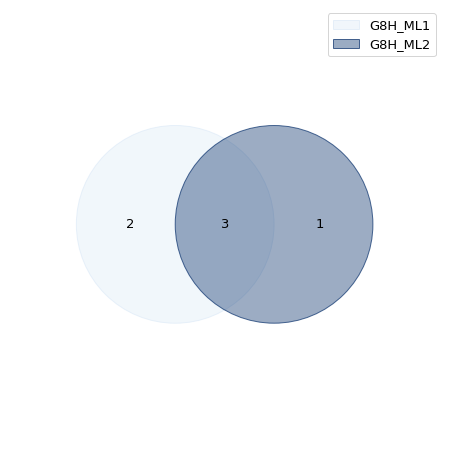

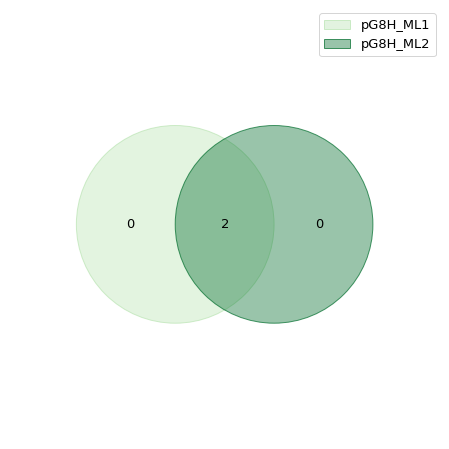

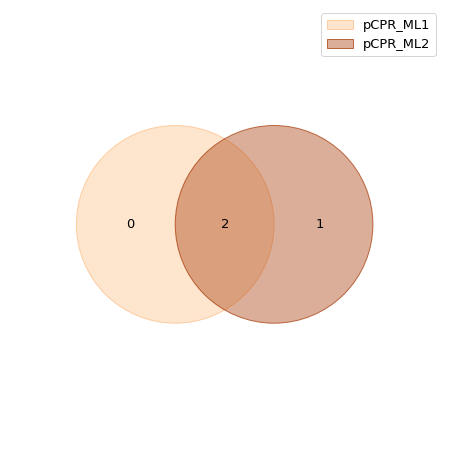

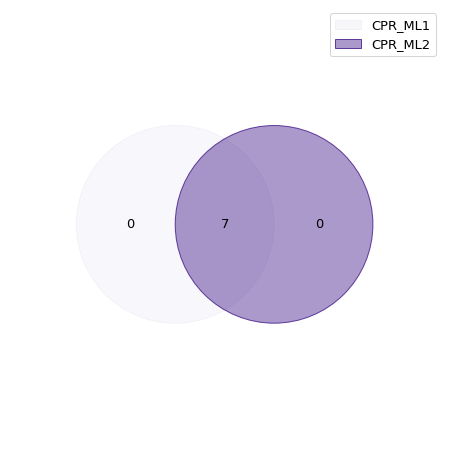

In [68]:
# G8H
venn(venn_dicts[0], cmap = [g8h_color[0], g8h_color[-1] ])
name = 'Venn_G8H'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/ML_DBTL1/'+name+'.svg',format = 'SVG',  dpi = 120)


# pG8H
venn(venn_dicts[1], cmap = [pg8H_color[0], pg8H_color[-1] ])
name = 'Venn_pG8H'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/ML_DBTL1/'+name+'.svg',format = 'SVG',  dpi = 120)


# pCPR
venn(venn_dicts[2], cmap = [pcpr_color[0], pcpr_color[-1] ])
name = 'Venn_pCPR'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/ML_DBTL1/'+name+'.svg',format = 'SVG',  dpi = 120)


# CPR
venn(venn_dicts[3], cmap = [cpr_color[1], cpr_color[-1] ])
name = 'Venn_CPR'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/ML_DBTL1/'+name+'.svg',format = 'SVG',  dpi = 120)



In [110]:
import plotly.graph_objs as go


In [70]:
#g8h_color = ['#0f7899', '#1188ad','#1397c0','#15a6d4','#16b5e7','#29bcea','#3cc2ec','#50c8ee']
#pg8H_color = ['#7cc57f', '#92ce95','#a8d8aa','#bde2bf']
#pcpr_color = ['#f7bd13', '#f9c83a','#fad362','#fbde89']
#cpr_color = ['#980007', '#cf0009','#ea000a','#ff0712','#ff222c','#ff3e46','#ff5a61','#ff757b','#ff9196','#ffacb0']

In [71]:
import matplotlib.colors

all_colours = g8h_color+ pg8H_color + pcpr_color + cpr_color

rgba_colors = []

for color in all_colours: 
    rgba_colors.append(matplotlib.colors.to_rgb(color))
rgba_colors

[(0.8705882352941177, 0.9215686274509803, 0.9686274509803922),
 (0.7764705882352941, 0.8588235294117647, 0.9372549019607843),
 (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
 (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
 (0.25882352941176473, 0.5725490196078431, 0.7764705882352941),
 (0.12941176470588237, 0.44313725490196076, 0.7098039215686275),
 (0.03137254901960784, 0.3176470588235294, 0.611764705882353),
 (0.03137254901960784, 0.18823529411764706, 0.4196078431372549),
 (0.7294117647058823, 0.8941176470588236, 0.7019607843137254),
 (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.0, 0.42745098039215684, 0.17254901960784313),
 (0.9921568627450981, 0.7450980392156863, 0.5215686274509804),
 (0.9921568627450981, 0.5529411764705883, 0.23529411764705882),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.6509803921568628, 0.21176470588235294, 0.01176470588235

In [72]:
import matplotlib.colors
>>> matplotlib.colors.to_rgb('#B4FBB8')

(0.7058823529411765, 0.984313725490196, 0.7215686274509804)

In [73]:
g8h_list_of_index = ["Cacu_G8H", "Opum_G8H","Cro_G8H","Vmin_G8H","Smus_G8H","Rsep_G8H","Oeu_G8H","Ccal_G8H"]
cpr_list_of_index = ["Cro_CPR", "Aan_CPR","Ara_CPR","Clo_CPR","Rse_CPR","Ahu_CPR","Ani_CPR","Cac_CPR","Oeu_CPR","Cpo_CPR"]
pg8h_list_of_index = ["CYC1", "ENO2","PCK1","RPL15B"]
pcpr_list_of_index = ["CCW12", "TPI1","MLS1","URE2"]

all_parts = g8h_list_of_index +cpr_list_of_index+ pg8h_list_of_index+pcpr_list_of_index

In [74]:
G8H_color_codes = dict(zip(g8h_list_of_index, g8h_color))
pG8H_color_codes = dict(zip(pg8h_list_of_index, pg8H_color))
pCPR_color_codes = dict(zip(pcpr_list_of_index, pcpr_color))
CPR_color_codes = dict(zip(cpr_list_of_index, cpr_color))
pG8H_color_codes

{'CYC1': '#bae4b3', 'ENO2': '#74c476', 'PCK1': '#31a354', 'RPL15B': '#006d2c'}

In [75]:
rgba_color_dict = dict(zip(all_parts, rgba_colors))
rgba_color_dict

{'Cacu_G8H': (0.8705882352941177, 0.9215686274509803, 0.9686274509803922),
 'Opum_G8H': (0.7764705882352941, 0.8588235294117647, 0.9372549019607843),
 'Cro_G8H': (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
 'Vmin_G8H': (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
 'Smus_G8H': (0.25882352941176473, 0.5725490196078431, 0.7764705882352941),
 'Rsep_G8H': (0.12941176470588237, 0.44313725490196076, 0.7098039215686275),
 'Oeu_G8H': (0.03137254901960784, 0.3176470588235294, 0.611764705882353),
 'Ccal_G8H': (0.03137254901960784, 0.18823529411764706, 0.4196078431372549),
 'Cro_CPR': (0.7294117647058823, 0.8941176470588236, 0.7019607843137254),
 'Aan_CPR': (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
 'Ara_CPR': (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 'Clo_CPR': (0.0, 0.42745098039215684, 0.17254901960784313),
 'Rse_CPR': (0.9921568627450981, 0.7450980392156863, 0.5215686274509804),
 'Ahu_CPR': (0.9921568627450981, 0.5529

In [79]:
colorDict = dict(G8H_color_codes, **pG8H_color_codes,**pCPR_color_codes, **CPR_color_codes)
colorDict

{'Cacu_G8H': '#deebf7',
 'Opum_G8H': '#c6dbef',
 'Cro_G8H': '#9ecae1',
 'Vmin_G8H': '#6baed6',
 'Smus_G8H': '#4292c6',
 'Rsep_G8H': '#2171b5',
 'Oeu_G8H': '#08519c',
 'Ccal_G8H': '#08306b',
 'CYC1': '#bae4b3',
 'ENO2': '#74c476',
 'PCK1': '#31a354',
 'RPL15B': '#006d2c',
 'CCW12': '#fdbe85',
 'TPI1': '#fd8d3c',
 'MLS1': '#e6550d',
 'URE2': '#a63603',
 'Cro_CPR': '#fcfbfd',
 'Aan_CPR': '#efedf5',
 'Ara_CPR': '#dadaeb',
 'Clo_CPR': '#bcbddc',
 'Rse_CPR': '#9e9ac8',
 'Ahu_CPR': '#807dba',
 'Ani_CPR': '#6a51a3',
 'Cac_CPR': '#54278f',
 'Oeu_CPR': '#3f007d',
 'Cpo_CPR': '#2d007d'}

In [80]:
df_20= df[:20]
df_20

,G8H,pG8H,pCPR,CPR,predict
0,Cro,ENO2,TPI1,Ara,154
1,Cro,ENO2,TPI1,Clo,152
2,Smus,ENO2,TPI1,Aan,129
3,Smus,ENO2,CCW12,Clo,125
4,Cro,ENO2,TPI1,Rse,123
5,Rsep,ENO2,TPI1,Aan,123
6,Cro,ENO2,TPI1,Cro,121
7,Smus,ENO2,TPI1,Clo,120
8,Rsep,ENO2,TPI1,Ara,117
9,Rsep,ENO2,TPI1,Clo,115


In [81]:
G8H_counts = df_20['G8H'].value_counts()
pG8H_counts = df_20['pG8H'].value_counts()
pCPR_counts = df_20['pCPR'].value_counts()
CPR_counts = df_20['CPR'].value_counts()

#total = sum(my_dict.values())


print(G8H_counts)

Cro     8
Smus    6
Rsep    6
Name: G8H, dtype: int64


In [82]:
counts = dict(G8H_counts, **pG8H_counts,**pCPR_counts, **CPR_counts)
total = sum(counts.values())
total
counts

{'Cro': 1,
 'Smus': 6,
 'Rsep': 6,
 'ENO2': 20,
 'TPI1': 10,
 'CCW12': 10,
 'Ara': 5,
 'Clo': 5,
 'Aan': 5,
 'Rse': 4}

In [83]:
color_list = []

i = 0

for k,v in rgba_color_dict.items():
    lst = [i, k, v]
    color_list.append(lst)
    i += 1
color_list       

[[0, 'Cacu_G8H', (0.8705882352941177, 0.9215686274509803, 0.9686274509803922)],
 [1, 'Opum_G8H', (0.7764705882352941, 0.8588235294117647, 0.9372549019607843)],
 [2, 'Cro_G8H', (0.6196078431372549, 0.792156862745098, 0.8823529411764706)],
 [3, 'Vmin_G8H', (0.4196078431372549, 0.6823529411764706, 0.8392156862745098)],
 [4,
  'Smus_G8H',
  (0.25882352941176473, 0.5725490196078431, 0.7764705882352941)],
 [5,
  'Rsep_G8H',
  (0.12941176470588237, 0.44313725490196076, 0.7098039215686275)],
 [6, 'Oeu_G8H', (0.03137254901960784, 0.3176470588235294, 0.611764705882353)],
 [7,
  'Ccal_G8H',
  (0.03137254901960784, 0.18823529411764706, 0.4196078431372549)],
 [8, 'Cro_CPR', (0.7294117647058823, 0.8941176470588236, 0.7019607843137254)],
 [9, 'Aan_CPR', (0.4549019607843137, 0.7686274509803922, 0.4627450980392157)],
 [10,
  'Ara_CPR',
  (0.19215686274509805, 0.6392156862745098, 0.32941176470588235)],
 [11, 'Clo_CPR', (0.0, 0.42745098039215684, 0.17254901960784313)],
 [12, 'Rse_CPR', (0.992156862745098

In [84]:
df_nodes = pd.DataFrame(color_list, columns = ['ID', 'Label', 'Color'])
df_nodes

,ID,Label,Color
0,0,Cacu_G8H,"(0.8705882352941177, 0.9215686274509803, 0.968..."
1,1,Opum_G8H,"(0.7764705882352941, 0.8588235294117647, 0.937..."
2,2,Cro_G8H,"(0.6196078431372549, 0.792156862745098, 0.8823..."
3,3,Vmin_G8H,"(0.4196078431372549, 0.6823529411764706, 0.839..."
4,4,Smus_G8H,"(0.25882352941176473, 0.5725490196078431, 0.77..."
5,5,Rsep_G8H,"(0.12941176470588237, 0.44313725490196076, 0.7..."
6,6,Oeu_G8H,"(0.03137254901960784, 0.3176470588235294, 0.61..."
7,7,Ccal_G8H,"(0.03137254901960784, 0.18823529411764706, 0.4..."
8,8,Cro_CPR,"(0.7294117647058823, 0.8941176470588236, 0.701..."
9,9,Aan_CPR,"(0.4549019607843137, 0.7686274509803922, 0.462..."


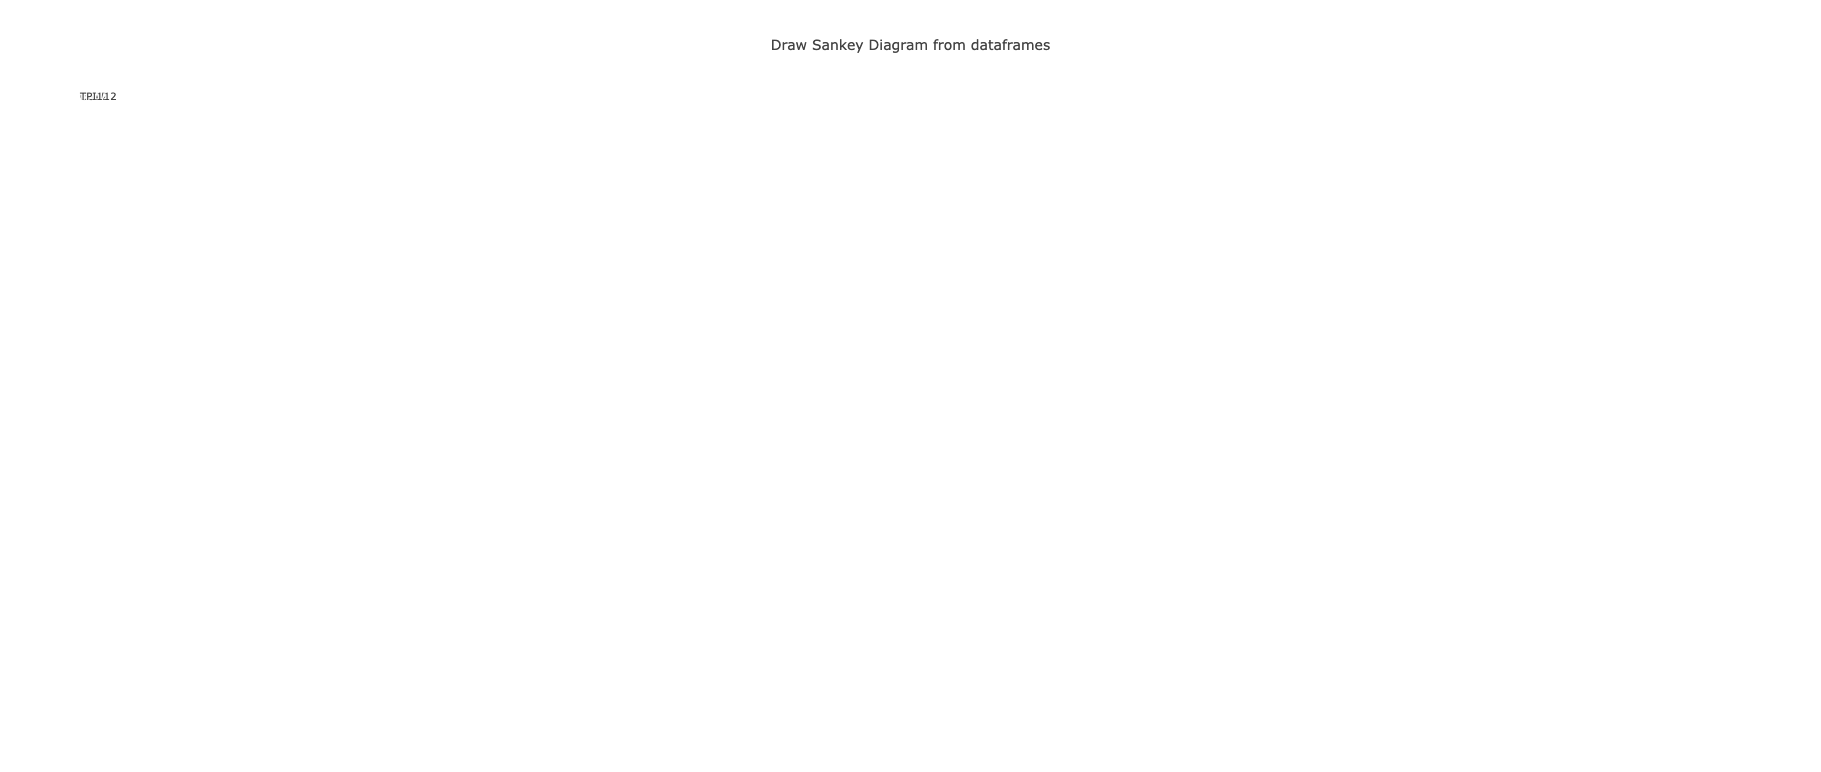

In [86]:
# imports
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)



# Retrieve headers and build dataframes
#nodes_headers = nodes.pop(0)
#inks_headers = links.pop(0)
#df_nodes = pd.DataFrame(nodes, columns = nodes_headers)
#df_links = pd.DataFrame(links, columns = links_headers)

# Sankey plot setup
data_trace = dict(
    type='sankey',
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
    # thickness = 30,
      line = dict(
        color = "black",
        width = 0
      ),
      label =  df_nodes['Label'].dropna(axis=0, how='any'),
      color = df_nodes['Color']
    ),
    link = dict(
      source = df_links['Source'].dropna(axis=0, how='any'),
      target = df_links['Target'].dropna(axis=0, how='any'),
      value = df_links['Value'].dropna(axis=0, how='any'),
      color = df_links['Link Color'].dropna(axis=0, how='any'),
  )
)

layout = dict(
        title = "Draw Sankey Diagram from dataframes",
    height = 772,
    font = dict(
      size = 10),)

fig = dict(data=[data_trace], layout=layout)
iplot(fig, validate=False)


In [130]:
#df_nodes = pd.DataFrame(nodes, columns = nodes_headers)
#df_links = pd.DataFrame(links, columns = links_headers)
#df_links

In [131]:
df

,G8H,pG8H,pCPR,CPR,predict
0,Rsep,ENO2,TPI1,Clo,255
1,Smus,ENO2,TPI1,Clo,246
2,Rsep,ENO2,TPI1,Ara,215
3,Smus,ENO2,TPI1,Rse,197
4,Smus,ENO2,TPI1,Aan,182
...,...,...,...,...,...
1109,Ccal,PCK1,CCW12,Ara,4
1110,Vmin,CYC1,URE2,Ani,4
1111,Smus,CYC1,URE2,Cac,4
1112,Rsep,ENO2,MLS1,Ahu,3


In [132]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113
G8H,Rsep,Smus,Rsep,Smus,Smus,Rsep,Rsep,Smus,Oeu,Smus,...,Ccal,Ccal,Ccal,Smus,Ccal,Ccal,Vmin,Smus,Rsep,Smus
pG8H,ENO2,ENO2,ENO2,ENO2,ENO2,ENO2,ENO2,CYC1,ENO2,ENO2,...,RPL15B,RPL15B,PCK1,PCK1,PCK1,PCK1,CYC1,CYC1,ENO2,CYC1
pCPR,TPI1,TPI1,TPI1,TPI1,TPI1,TPI1,TPI1,TPI1,TPI1,CCW12,...,TPI1,MLS1,CCW12,CCW12,CCW12,CCW12,URE2,URE2,MLS1,URE2
CPR,Clo,Clo,Ara,Rse,Aan,Aan,Cro,Ani,Aan,Clo,...,Cpo,Cpo,Cro,Ahu,Aan,Ara,Ani,Cac,Ahu,Ani
predict,255,246,215,197,182,165,143,136,123,121,...,5,5,5,4,4,4,4,4,3,3


## Stacked barplot of top predicted combinations from the combinatorial library

In [87]:
def_merged = df4[['G8H', 'pG8H','pCPR','CPR']]

def_merged['G8H'] = def_merged['G8H']+'_G8H'
def_merged['CPR'] = def_merged['CPR']+'_CPR'
def_merged['Index'] = def_merged.index
def_merged.head(50)

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_12212/2356017408.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_12212/2356017408.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_12212/2356017408.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

,G8H,pG8H,pCPR,CPR,Index
0,Smus_G8H,ENO2,TPI1,Cac_CPR,0
1,Smus_G8H,ENO2,TPI1,Oeu_CPR,1
2,Smus_G8H,ENO2,TPI1,Cro_CPR,2
3,Smus_G8H,ENO2,TPI1,Aan_CPR,3
4,Smus_G8H,ENO2,TPI1,Clo_CPR,4
5,Smus_G8H,ENO2,TPI1,Rse_CPR,5
6,Smus_G8H,ENO2,TPI1,Ahu_CPR,6
7,Smus_G8H,ENO2,TPI1,Ani_CPR,7
8,Smus_G8H,ENO2,TPI1,Cpo_CPR,8
9,Smus_G8H,ENO2,CCW12,Clo_CPR,9


In [88]:
list_of_parts = []
parst_index = []

for index, row in def_merged.iterrows():
    list_of_parts.append(row['G8H'])
    list_of_parts.append(row['pG8H'])
    list_of_parts.append(row['pCPR'])
    list_of_parts.append(row['CPR'])
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)


distribution = [25]*len(parst_index)
print(len(list_of_parts))
print(len(parst_index))
print(len(distribution))

4476
4476
4476


In [89]:
d = {'Index':parst_index,'Part':list_of_parts, 'Distribution':distribution }
df2 = pd.DataFrame(d)
df2

,Index,Part,Distribution
0,0,Smus_G8H,25
1,0,ENO2,25
2,0,TPI1,25
3,0,Cac_CPR,25
4,1,Smus_G8H,25
...,...,...,...
4471,1117,Rse_CPR,25
4472,1118,Cacu_G8H,25
4473,1118,CYC1,25
4474,1118,TPI1,25


In [90]:
len(parst_index)

4476

In [91]:
all_parts = ['CacuG8H',
 'OpumG8H',
 'CroG8H',
 'VminG8H',
 'SmusG8H',
 'RsepG8H',
 'OeuG8H',
 'CcalG8H',
 'CroCPR',
 'AanCPR',
 'AraCPR',
 'CloCPR',
 'RseCPR',
 'AhuCPR',
 'AniCPR',
 'CacCPR',
 'OeuCPR',
 'CpoCPR',
 'CYC1',
 'ENO2',
 'PCK1',
 'RPL15B',
 'CCW12',
 'TPI1',
 'MLS1',
 'URE2']

In [92]:
df2

,Index,Part,Distribution
0,0,Smus_G8H,25
1,0,ENO2,25
2,0,TPI1,25
3,0,Cac_CPR,25
4,1,Smus_G8H,25
...,...,...,...
4471,1117,Rse_CPR,25
4472,1118,Cacu_G8H,25
4473,1118,CYC1,25
4474,1118,TPI1,25


In [93]:
df100 = df2[:400]
df100.head(20)

,Index,Part,Distribution
0,0,Smus_G8H,25
1,0,ENO2,25
2,0,TPI1,25
3,0,Cac_CPR,25
4,1,Smus_G8H,25
5,1,ENO2,25
6,1,TPI1,25
7,1,Oeu_CPR,25
8,2,Smus_G8H,25
9,2,ENO2,25


In [94]:
### prøve 4
df100

cross_tab_prop = pd.crosstab(index=df100['Index'],
                             columns=df100['Part'])
cross_tab_prop

Part,Aan_CPR,Ahu_CPR,Ani_CPR,Ara_CPR,CCW12,CYC1,Cac_CPR,Clo_CPR,Cpo_CPR,Cro_CPR,Cro_G8H,ENO2,Oeu_CPR,Oeu_G8H,Rse_CPR,Rsep_G8H,Smus_G8H,TPI1,URE2,Vmin_G8H
Index,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0
2,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0
3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0
4,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0
96,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
97,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0


In [95]:
coloumns = list(cross_tab_prop.columns)
coloumns

['Aan_CPR',
 'Ahu_CPR',
 'Ani_CPR',
 'Ara_CPR',
 'CCW12',
 'CYC1',
 'Cac_CPR',
 'Clo_CPR',
 'Cpo_CPR',
 'Cro_CPR',
 'Cro_G8H',
 'ENO2',
 'Oeu_CPR',
 'Oeu_G8H',
 'Rse_CPR',
 'Rsep_G8H',
 'Smus_G8H',
 'TPI1',
 'URE2',
 'Vmin_G8H']

In [96]:
all_parts = ['Cacu_G8H',
 'Opum_G8H',
 'Cro_G8H',
 'Vmin_G8H',
 'Smus_G8H',
 'Rsep_G8H',
 'Oeu_G8H',
 'Ccal_G8H',
 'CYC1',
 'ENO2',
 'PCK1',
 'RPL15B',
 'CCW12',
 'TPI1',
 'MLS1',
 'URE2',    
 'Cro_CPR',
 'Aan_CPR',
 'Ara_CPR',
 'Clo_CPR',
 'Rse_CPR',
 'Ahu_CPR',
 'Ani_CPR',
 'Cac_CPR',
 'Oeu_CPR',
 'Cpo_CPR']

In [97]:
#all_parts = all_parts[::-1]
all_parts

['Cacu_G8H',
 'Opum_G8H',
 'Cro_G8H',
 'Vmin_G8H',
 'Smus_G8H',
 'Rsep_G8H',
 'Oeu_G8H',
 'Ccal_G8H',
 'CYC1',
 'ENO2',
 'PCK1',
 'RPL15B',
 'CCW12',
 'TPI1',
 'MLS1',
 'URE2',
 'Cro_CPR',
 'Aan_CPR',
 'Ara_CPR',
 'Clo_CPR',
 'Rse_CPR',
 'Ahu_CPR',
 'Ani_CPR',
 'Cac_CPR',
 'Oeu_CPR',
 'Cpo_CPR']

In [98]:
fixed_columns = []
for name in all_parts: 
    
    if name in coloumns: 
        fixed_columns.append(name)
fixed_columns

cross_tab_prop = cross_tab_prop[fixed_columns]

In [99]:
cross_tab_prop

Part,Cro_G8H,Vmin_G8H,Smus_G8H,Rsep_G8H,Oeu_G8H,CYC1,ENO2,CCW12,TPI1,URE2,Cro_CPR,Aan_CPR,Ara_CPR,Clo_CPR,Rse_CPR,Ahu_CPR,Ani_CPR,Cac_CPR,Oeu_CPR,Cpo_CPR
Index,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
2,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
96,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0
97,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1


In [100]:
#  Returns tuple of handles, labels for axis ax, after reordering them to conform to the label order `order`, and if unique is True, after removing entries with duplicate labels.
def reorderLegend(ax=None,order=None,unique=False):
    if ax is None: ax=plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0])) # sort both labels and handles by labels
    if order is not None: # Sort according to a given list (not necessarily complete)
        keys=dict(zip(order,range(len(order))))
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t,keys=keys: keys.get(t[0],np.inf)))
    if unique:  labels, handles= zip(*unique_everseen(zip(labels,handles), key = labels)) # Keep only the first of each handle
    ax.legend(handles, labels)
    return(handles, labels)

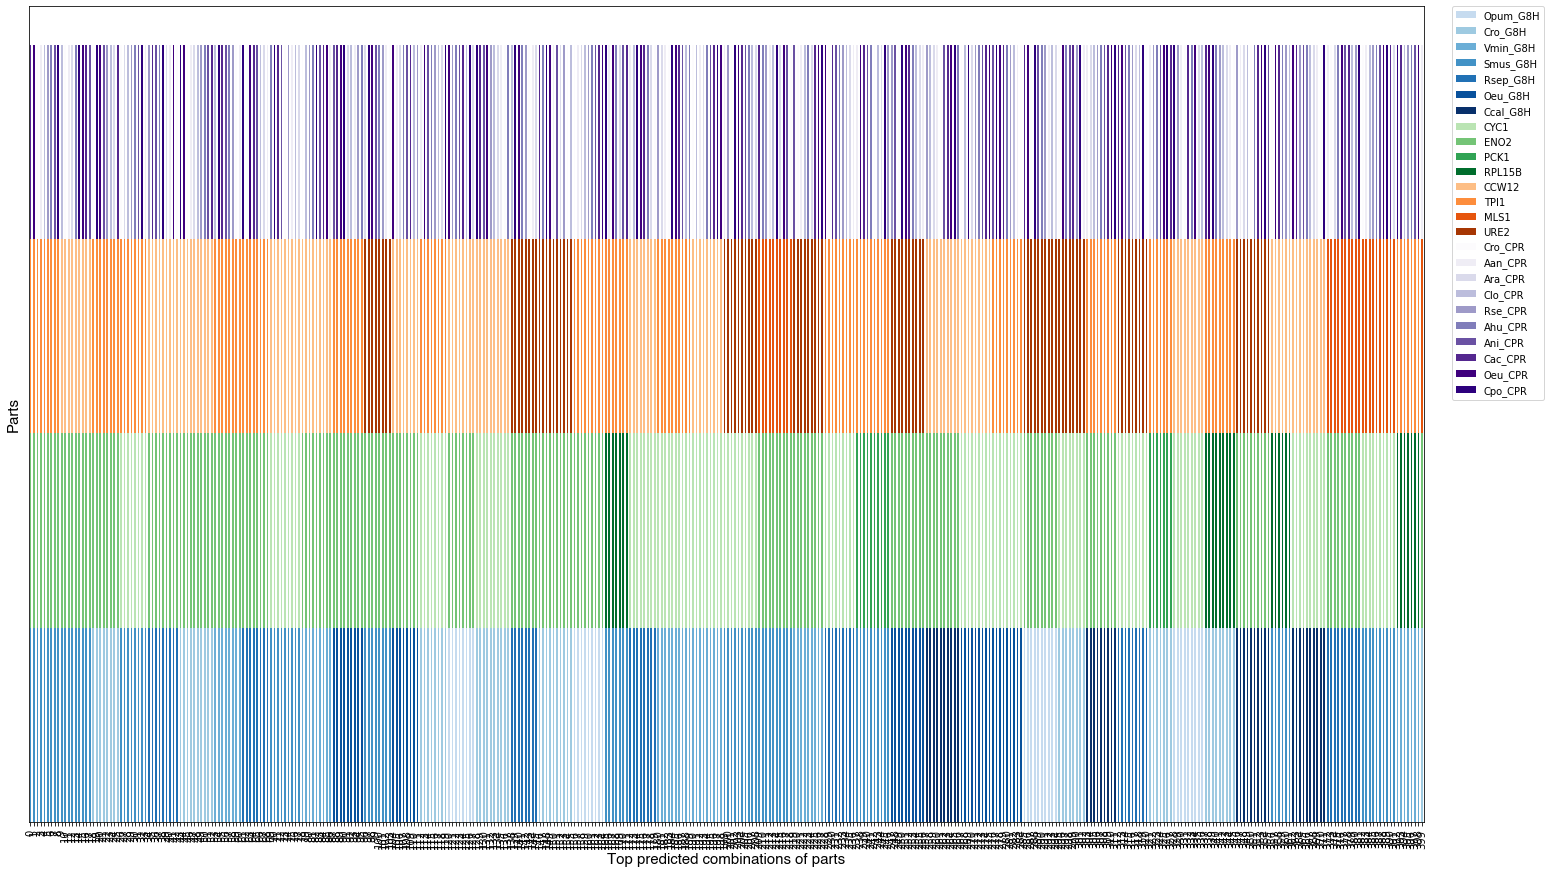

In [110]:
import matplotlib as mpl

#### How can I export a matplotlib figure as a vector graphic with editable text fields?
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


import matplotlib.pyplot as plt

# Plot
ax = cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    #colormap='tab10', 
                    figsize=(20, 6),  color=colorDict)

plt.legend(loc="upper right", ncol=2)
plt.xlabel("Top predicted combinations of parts",  size = 15, fontname='Helvetica')
plt.ylabel("Parts",  size = 15, fontname='Helvetica')

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# remove y axis labes
plt.yticks([])

## size matters 
fig = mpl.pyplot.gcf()
fig.set_size_inches(25, 15)


## save
name = 'Best_combinations_predicted_by_the_ML_'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/ML_DBTL1/'+name+'.svg',format = 'SVG',  dpi = 120,bbox_inches='tight')

#reorderLegend(ax,all_parts)

plt.show()

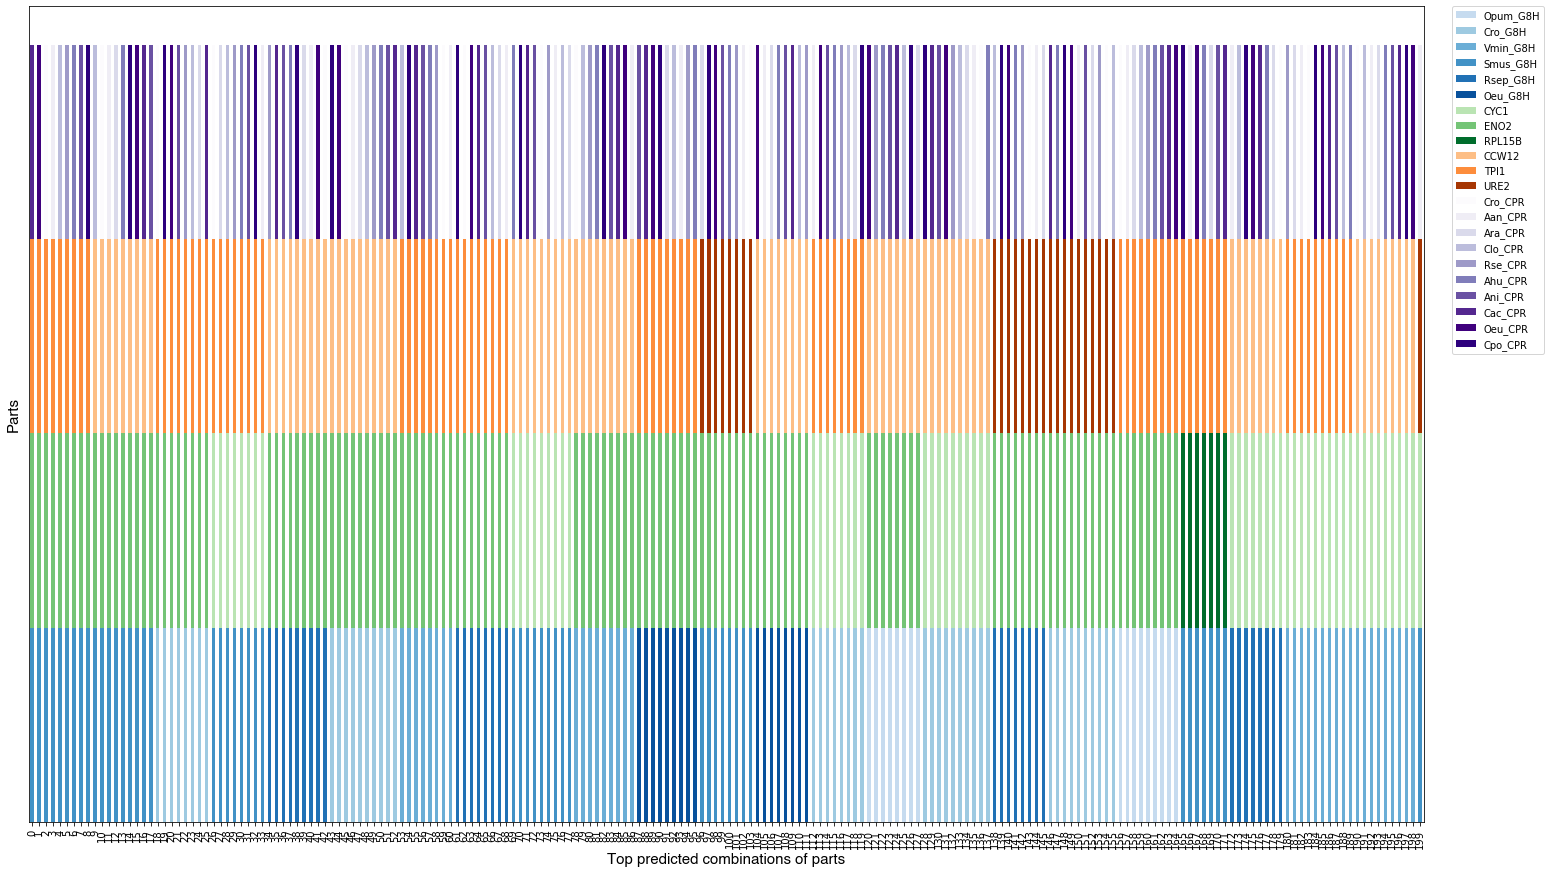

In [108]:
df200 = df2[:800]
df200.head(20)

cross_tab_prop = pd.crosstab(index=df200['Index'],
                             columns=df200['Part'])
coloumns = list(cross_tab_prop.columns)


fixed_columns = []
for name in all_parts: 
    
    if name in coloumns: 
        fixed_columns.append(name)
fixed_columns

cross_tab_prop = cross_tab_prop[fixed_columns]



import matplotlib as mpl

#### How can I export a matplotlib figure as a vector graphic with editable text fields?
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


import matplotlib.pyplot as plt

# Plot
ax = cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    #colormap='tab10', 
                    figsize=(20, 6),  color=colorDict)

plt.legend(loc="upper right", ncol=2)
plt.xlabel("Top predicted combinations of parts",  size = 15, fontname='Helvetica')
plt.ylabel("Parts",  size = 15, fontname='Helvetica')

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# remove y axis labes
plt.yticks([])


## size matters 
fig = mpl.pyplot.gcf()
fig.set_size_inches(25, 15)


## save
name = 'Best_combinations_predicted_by_the_ML_200'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/ML_DBTL1/'+name+'.svg',format = 'SVG',  dpi = 120,bbox_inches='tight')

#reorderLegend(ax,all_parts)

plt.show()

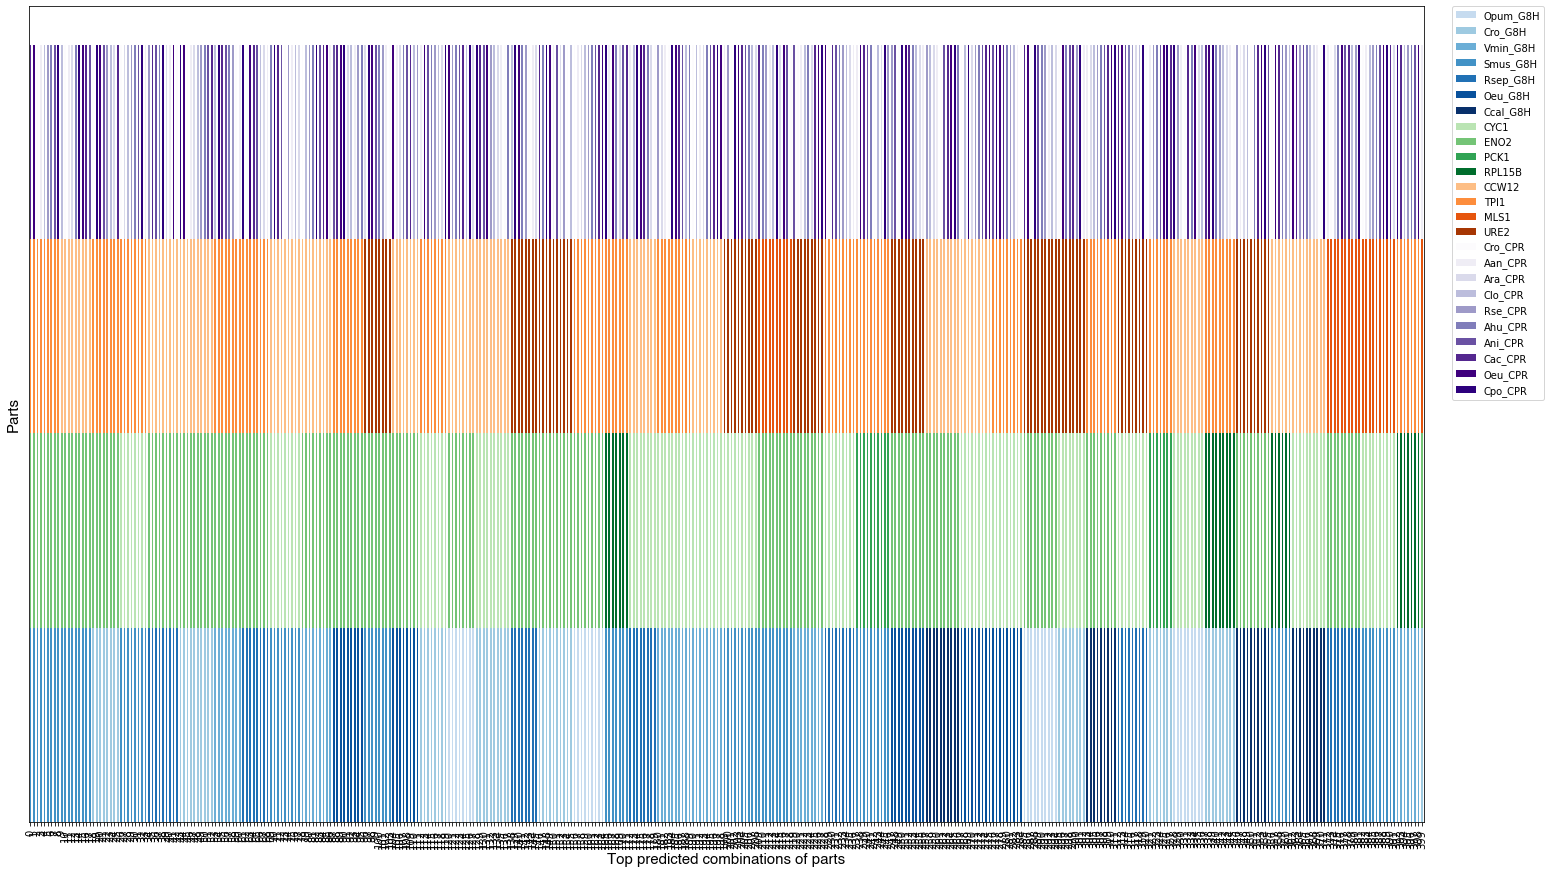

In [109]:
df200 = df2[:1600]
df200.head(20)

cross_tab_prop = pd.crosstab(index=df200['Index'],
                             columns=df200['Part'])
coloumns = list(cross_tab_prop.columns)


fixed_columns = []
for name in all_parts: 
    
    if name in coloumns: 
        fixed_columns.append(name)
fixed_columns

cross_tab_prop = cross_tab_prop[fixed_columns]



import matplotlib as mpl

#### How can I export a matplotlib figure as a vector graphic with editable text fields?
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


import matplotlib.pyplot as plt

# Plot
ax = cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    #colormap='tab10', 
                    figsize=(20, 6),  color=colorDict)

plt.legend(loc="upper right", ncol=2)
plt.xlabel("Top predicted combinations of parts",  size = 15, fontname='Helvetica')
plt.ylabel("Parts",  size = 15, fontname='Helvetica')

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# remove y axis labes
plt.yticks([])

## size matters 
fig = mpl.pyplot.gcf()
fig.set_size_inches(25, 15)


## save
name = 'Best_combinations_predicted_by_the_ML_400'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/ML_DBTL1/'+name+'.svg',format = 'SVG',  dpi = 120,bbox_inches='tight')

#reorderLegend(ax,all_parts)

plt.show()

From this outcome, the parts encountered in the first 20 predictions from the RMSE were taken, resulting in 140 combinations and 35 transformations. 

# 4. ML discussion

ML distribution:
quite objectively, we see that the most represented genes are
biologically speaking, the promoters are first the high-low, and then the constitutive high.


To choose which genes to proceed with, we say that we have to say from the top that we have 4 parts, each time we gpr down the list we add a part if a new one is represented. When we have the number of parts that together gives 180 (e.g. 4*3*3*5) we stop. these must be used. But some may have to be taken away if there are too many plates. then make the quadrature showing the distribution of parts in each part. This is to be discussed. it is interesting that we see

We follow the sampling theory where we say if there are 180 possible, then we will also sample 180. ie. if we have 20 plates, we take 9 from each, as there should be 9 possible combinations on a plate.


We will fill the design space with these recomendations


My round is optimal sampling -> in that we will sample the number of possible combinations there are.
first round was not optimal because we did not sample 1200 oga capacity. We will this time since we have it.
if we had more finds we would be more exploratory - in that we would then have more time to fill out the design space - because we still want to sample the number of possible ones. but in this case we will try to make it as "hurtgit/smart" as possible with the two rounds we have. Therefore, we try to find one of the best in the second round, based on the recommendations we have received in the first round.

the goal is to make one of the best in the shortest time. not the best, because then we might as well just do all of them. instead, we would like to spend our time finding the best one in several places in the pathway, which is why we prioritize making 2 iterations. the solution space is so large that we can't do all of them either.


If I want, I can do machine learning after the second iteration and look at the change in mae.

add image of promoters to understand them

I can see that the promoters are quite stable, we should only have two of each (which are the highly expressed ones). On the other hand, CPR is not very stable in that there are 7 different ones within the first 25 predictions. that is to say that they are probably not that important for how 'high' it is expressed - On the other hand, they are very important for f¨elstra G8H, and here they are probably a little more important.